<a href="https://colab.research.google.com/github/ssoyyoungg/practice/blob/main/Precision%2CRecall%2CF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binary Classification으로 전환

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

classes = ('vehicle', 'animal')

def  binary_label(label):
  vehicle_classes = [0,1,8,9]
  return 0 if label in vehicle_classes else 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ✅ pretrained ResNet에 맞는 Normalize (최소 필수)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
train_dataset.targets = [binary_label(i) for i in train_dataset.targets]

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
test_dataset.targets = [binary_label(i) for i in test_dataset.targets]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ CIFAR10용 ResNet18 패치
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 2) # 모델 2개 출력으로 변경
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

device: cuda


100%|██████████| 170M/170M [00:18<00:00, 9.00MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


In [ ]:
for epoch in range(1,6):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | /Train Loss : {train_loss:.4f} | Test Acc : {test_acc*100:.2f}%")

Epoch 1 | /Train Loss : 0.1661 | Test Acc : 96.50%
Epoch 2 | /Train Loss : 0.0859 | Test Acc : 97.40%
Epoch 3 | /Train Loss : 0.0661 | Test Acc : 97.75%
Epoch 4 | /Train Loss : 0.0521 | Test Acc : 98.00%
Epoch 5 | /Train Loss : 0.0417 | Test Acc : 98.16%


2X2 confusion matrix 만들기

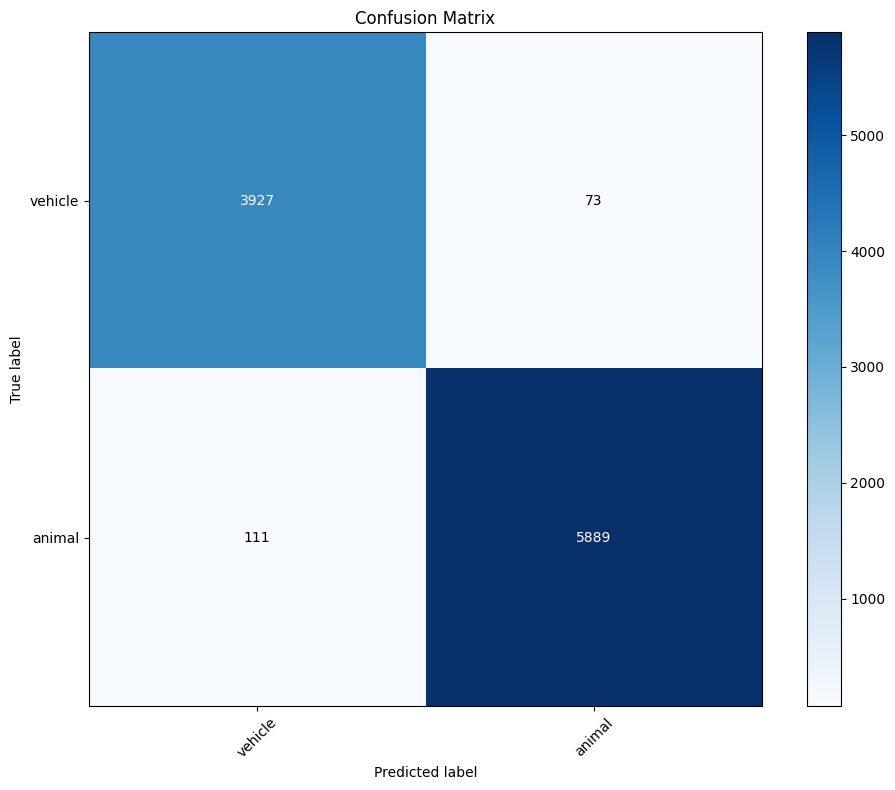

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 🔥 숫자 표시 부분
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


Precision/Recall/F1

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels,all_preds ))


              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4000
           1       0.99      0.98      0.98      6000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



ROC Curve + AUC

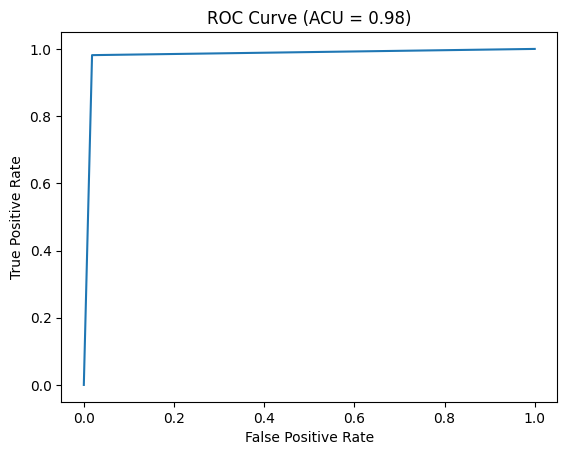

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ACU = {roc_auc:.2f})')
plt.show()


prob이 class 1인 확률 가져오기

In [ ]:
model.eval()
probs = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        softmax = torch.softmax(outputs, dim=1)
        probs.extend(softmax[:,1].cpu().numpy())  # class 1 확률
        true_labels.extend(labels.numpy())

ROC 기반 threshold 찾기

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, probs)

Sensitivity 0.99 이상 되는 threshold 찾기

In [ ]:
import numpy as np

idx = np.where(tpr >= 0.99)[0][0]
best_threshold = thresholds[idx]

print("Sensitivity for 99% threshold:", best_threshold)

Sensitivity for 99% threshold: 0.26105723


찾은 Threshold로 다시 예측

In [ ]:
preds_new = (np.array(probs) >= best_threshold).astype(int)

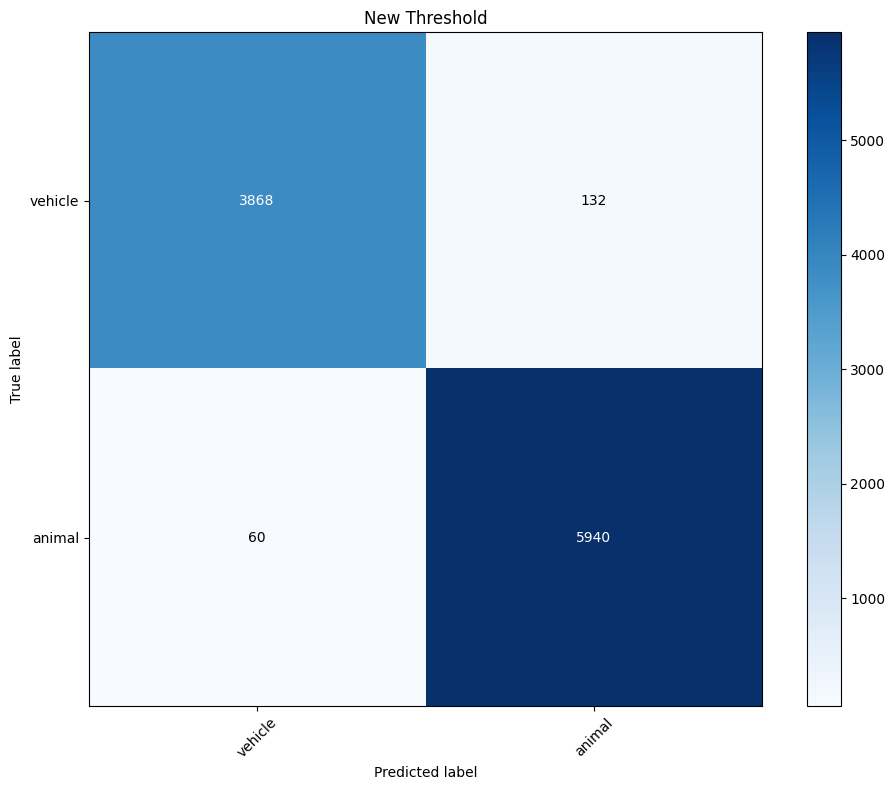

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)
        probs_pos = probs[:, 1]

        preds_new = (probs_pos >= best_threshold).long()

        all_preds.extend(preds_new.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("New Threshold")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 🔥 숫자 표시 부분
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


Class Imbalnace 실험(데이터 줄이기)


데이터 개수 확인

In [ ]:
import numpy as np
from torch.utils.data import Subset
from collections import Counter

targets = np.array(train_dataset.targets)
print(Counter(train_dataset.targets))

Counter({1: 30000, 0: 20000})


강한 불균형 만들기

subset 사용하는 이유 :

원본데이터는 그대로 두고 일부만 골라서 쓰게 해줌

In [ ]:
import numpy as np
from torch.utils.data import Subset
from collections import Counter

targets = np.array(train_dataset.targets)

idx0 = np.where(targets == 0)[0]   # vehicle
idx1 = np.where(targets == 1)[0]   # animal

np.random.seed(42)
keep1 = np.random.choice(idx1, size=1000, replace=False)  # animal 천장만 남김

new_indices = np.concatenate([idx0, keep1])
np.random.shuffle(new_indices)

train_dataset_imb = Subset(train_dataset, new_indices)

# 확인(Subset은 targets가 없으니, indices로 원본 targets에서 세기)
new_targets = targets[new_indices]
print("After:", Counter(new_targets))

After: Counter({np.int64(0): 20000, np.int64(1): 1000})


In [ ]:
print("unique labels : ", np.unique(targets)[:20],"...")

unique labels :  [0 1] ...


In [ ]:
train_loader = DataLoader(train_dataset_imb, batch_size=64, shuffle=True)

In [ ]:
for epoch in range(1,11):
  train_loss = train_one_epoch(model, train_loader)
  test_acc = evaluate(model, test_loader)
  print(epoch, train_loss, test_acc)

1 0.09081193627390478 0.9299
2 0.024669208290055394 0.9393
3 0.01806231430727279 0.9437
4 0.01515473981769312 0.9166
5 0.017888119113986335 0.9309
6 0.010658205325670895 0.9481
7 0.011045503388158977 0.9169
8 0.010061360754737897 0.9335
9 0.008850697556133604 0.9456
10 0.010512869882929538 0.9368


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels,all_preds ))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4000
           1       0.98      0.99      0.98      6000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

